In [1]:
#Time series prediction using LSTM with Pytorch 
#Codes are from: https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python

import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sns.get_dataset_names()
flight_data = sns.load_dataset("flights")
flight_data.head()



,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


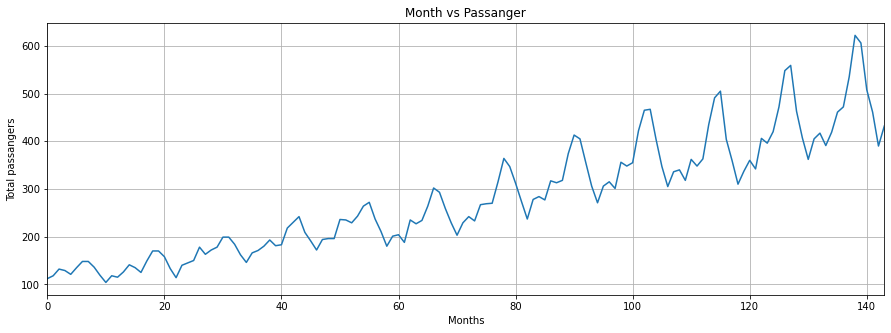

In [2]:
#Dataset has 144 months of record, which 132 will be used to train and last 12 to evaluate
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title("Month vs Passanger")
plt.ylabel("Total passangers")
plt.xlabel("Months")
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])

In [3]:
#Preprocessing

flight_data.columns
#cast object type to float for passengers
all_data = flight_data['passengers'].values.astype(float)
#print(all_data)

#As it was noted above, test months will be the last 12 month and training data will be the rest
test_data_size = 12
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data), len(test_data))

#Since the number of flights increased overall the years, this needs normalization. Normalization is only applied to training data.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))
#print(train_data_normalized[:5])
#print(train_data_normalized[-5:])
print(len(train_data_normalized))

132 12
132


In [5]:
#Transforming to PyTorch tensors
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized
#Sequencing: in this case our data is monthly which made sense to have input sequence length of 12.
#If the data had days rather than months it would be 365.
train_window=12

#This function helps us create 12 sequences. train_seq takes 1-12, train_label takes the 13th for the first iteration
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
        
    return inout_seq
    
    
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq



[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077])),
 (tensor([-0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385, -0.9516,
          -0.9033, -0.8374, -0.8637, -0.9077]),
  tensor([-0.8022])),
 (tensor([-0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385, -0.9516, -0.9033,
      

In [6]:
#Creating the LSTM
#Input size= represents features that will be used. In this example "passengers"
#Hidden layer size = represents amount of neurons in each layer

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [7]:
#LSTM model initiation, loss function, optimizer
model = LSTM()

#Cross entropy loss due to classification problem
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [8]:
#Training the model

epochs = 150
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1,1,model.hidden_layer_size), torch.zeros(1,1,model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i%25 == 1:
        print(f"epoch: {i:3} | loss: {single_loss.item():10.8f}")

print(f"epoch: {i:3} | loss: {single_loss.item():10.8f}")

epoch:   1 | loss: 0.00108025
epoch:  26 | loss: 0.00781969
epoch:  51 | loss: 0.00084960
epoch:  76 | loss: 0.00104077
epoch: 101 | loss: 0.00025230
epoch: 126 | loss: 0.00001379
epoch: 149 | loss: 0.00001880


In [13]:
#Making predictions, test_set was 12 moths
future_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
test_inputs 

model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_layer_size), torch.zeros(1,1,model.hidden_layer_size))
        test_inputs.append(model(seq).item())

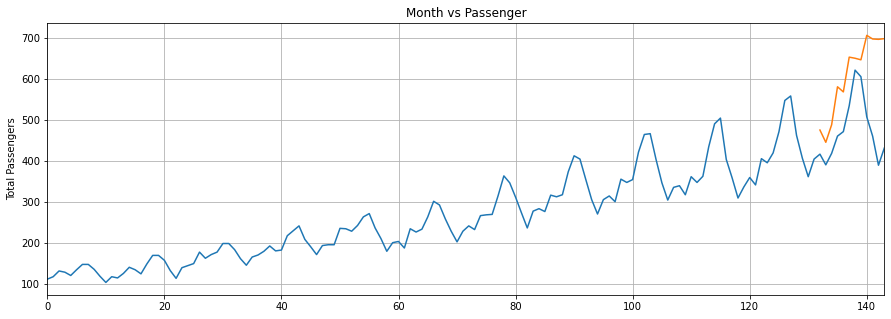

In [34]:
len(test_inputs)
test_inputs[future_pred:]

#Transform to normalized to original
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))
actual_predictions

#Plotting
#last 12 months' index creation
x = np.arange(132, 144, 1)

plt.title("Month vs Passenger")
plt.ylabel("Total Passengers")
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x, actual_predictions)
plt.show()

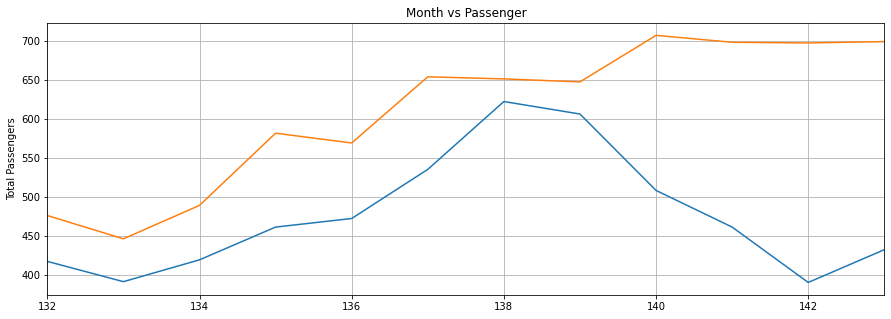

In [35]:
#Another view of output

plt.title("Month vs Passenger")
plt.ylabel("Total Passengers")
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x, actual_predictions)
plt.show()